In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

In [4]:
dataset = tf.keras.utils.get_file("stack_overflow_16k", url, untar=True, cache_dir='.', cache_subdir='')

In [5]:
!ls

README.md  stack.ipynb	stack_overflow_16k.tar.gz  test  train


In [6]:
train_dir = os.path.join('train')

In [7]:
!ls train

csharp	java  javascript  python


In [8]:
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [9]:
sample_file1 = os.path.join(train_dir, 'java/1.txt')

In [10]:
with open(sample_file1) as f:
    print(f.read())

"add version to @@webservice i'm using blankx.jws.webservice to create my webservice, in addition to targetnamespace i would like to include a ""version"" attribute to mark the version of my service. what other tag can i use in addition to this one to accomplish this so my wdsl will look like:..&lt;schema targetnamespace=""http://example.com/2009/02/15/webservice"" version=""1.1"" xmlns=""http://www.w3.org/2000/10/xmlschema&gt;...i.e. it has a version attribute"



In [11]:
sample_file2 = os.path.join(train_dir, 'python/1755.txt')
with open(sample_file2) as f:
    print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



In [12]:
sample_file3 = os.path.join(train_dir, 'javascript/17.txt')
with open(sample_file3) as f:
    print(f.read())

"replace prototype dynamically by changing constructor property i am trying to make some good code example to experience blank's ""classlessness"". this is what i have come up with so far:..function one() {}.function two() {}..one.prototype.a = 5;.two.prototype.b = 4;..var obj = new one();.print(""1) ctor ="", obj.constructor, ""a ="", obj.a, "" b ="", obj.b);.obj.constructor = two;.print(""1) ctor ="", obj.constructor, ""a ="", obj.a, "" b ="", obj.b);..var objtwo = new obj.constructor();.print(""2) ctor ="", objtwo.constructor, ""a ="", objtwo.a, "" b ="", objtwo.b);...and these are corresponding prints:..1) ctor = function one() {.} a = 5  b = undefined.1) ctor = function two() {.} a = 5  b = undefined.2) ctor = function two() {.} a = undefined  b = 4...my question is why prototype chain does not work here by the book? i run my example in ideone with blank (spidermonkey) (spidermonkey-1.7). it looks like in real life prototype is accessed somehow else than constructor.prototype?..p.

In [13]:
batch_size = 16
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.20, subset='training', seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2022-03-23 17:35:39.005508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 17:35:39.021727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/:/usr/local/lib:/usr/local/lib/fst:/usr/local/lib:/usr/local/lib/fst
2022-03-23 17:35:39.023480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/:/usr/local/lib:/usr/local/lib/fst:/usr/local/lib:/usr/local/lib/fst
2022-03-23 17:35:39.023536: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make s

In [14]:
# print("Label 0 corresponds to", raw_train_ds.class_names[0])
# print("Label 1 corresponds to", raw_train_ds.class_names[1])
# print("Label 2 corresponds to", raw_train_ds.class_names[2])
# print("Label 3 corresponds to", raw_train_ds.class_names[3])

for i, label in enumerate(raw_train_ds.class_names):
    print("Label:", i, "corresponding to:", label)

Label: 0 corresponding to: csharp
Label: 1 corresponding to: java
Label: 2 corresponding to: javascript
Label: 3 corresponding to: python


In [15]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [16]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('test', batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [18]:
VOCAB_SIZE = 10000
# binary_vectorize_layer = layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='binary')
MAX_SEQUENCE_LENGTH = 250

In [19]:
int_vectorize_layer = layers.TextVectorization(max_tokens=VOCAB_SIZE,output_mode='int', output_sequence_length=MAX_SEQUENCE_LENGTH)

In [20]:
# We do not want label
train_text = raw_train_ds.map(lambda text, label: text)

In [22]:
int_vectorize_layer.adapt(train_text)

In [69]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

In [34]:
embedding_dim = 16


In [35]:
model = tf.keras.Sequential([
  layers.Embedding(VOCAB_SIZE + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)] 
)

In [36]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [39]:
epochs = 20

In [40]:
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=epochs)

Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.4714 - accuracy: 0.8622 - val_loss: 0.5524 - val_accuracy: 0.8144
Epoch 2/20
400/400 [==============================] - 2s 6ms/step - loss: 0.4497 - accuracy: 0.8714 - val_loss: 0.5382 - val_accuracy: 0.8150
Epoch 3/20
400/400 [==============================] - 2s 5ms/step - loss: 0.4267 - accuracy: 0.8823 - val_loss: 0.5266 - val_accuracy: 0.8219
Epoch 4/20
400/400 [==============================] - 2s 4ms/step - loss: 0.4109 - accuracy: 0.8869 - val_loss: 0.5168 - val_accuracy: 0.8250
Epoch 5/20
400/400 [==============================] - 2s 5ms/step - loss: 0.3895 - accuracy: 0.8961 - val_loss: 0.5087 - val_accuracy: 0.8269
Epoch 6/20
400/400 [==============================] - 2s 4ms/step - loss: 0.3724 - accuracy: 0.8997 - val_loss: 0.5012 - val_accuracy: 0.8256
Epoch 7/20
400/400 [==============================] - 2s 5ms/step - loss: 0.3549 - accuracy: 0.9066 - val_loss: 0.4938 - val_accuracy: 0.8275
Epoch 

In [41]:
loss, accuracy = model.evaluate(int_test_ds)

500/500 [==============================] - 1s 2ms/step - loss: 0.5312 - accuracy: 0.8033


In [42]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
len(history_dict)

4

In [44]:
acc = history_dict['accuracy']

In [45]:
acc

[0.8621875047683716,
 0.8714062571525574,
 0.8823437690734863,
 0.8868749737739563,
 0.8960937261581421,
 0.8996875286102295,
 0.9065625071525574,
 0.9071875214576721,
 0.9139062762260437,
 0.9182812571525574,
 0.9209374785423279,
 0.9251562356948853,
 0.9292187690734863,
 0.9321874976158142,
 0.9357812404632568,
 0.9381250143051147,
 0.940625011920929,
 0.9424999952316284,
 0.9471874833106995,
 0.9512500166893005]

In [46]:
val_acc = history_dict['val_accuracy']

In [47]:
val_acc

[0.8143749833106995,
 0.8149999976158142,
 0.8218749761581421,
 0.824999988079071,
 0.8268749713897705,
 0.8256250023841858,
 0.8274999856948853,
 0.8299999833106995,
 0.8268749713897705,
 0.8318750262260437,
 0.8306249976158142,
 0.8274999856948853,
 0.8293750286102295,
 0.831250011920929,
 0.8343750238418579,
 0.831250011920929,
 0.8343750238418579,
 0.8299999833106995,
 0.8293750286102295,
 0.8324999809265137]

In [48]:
loss = history_dict['loss']

In [49]:
loss

[0.47139686346054077,
 0.44969165325164795,
 0.42669355869293213,
 0.410861998796463,
 0.3894678056240082,
 0.37238940596580505,
 0.3548586666584015,
 0.342479944229126,
 0.32644790410995483,
 0.3139822483062744,
 0.3007865250110626,
 0.2887516915798187,
 0.2757001519203186,
 0.26330289244651794,
 0.2562512457370758,
 0.2453950047492981,
 0.23443889617919922,
 0.22616048157215118,
 0.21651601791381836,
 0.20492671430110931]

In [50]:
val_loss = history_dict['val_loss']

In [51]:
val_loss

[0.5524168014526367,
 0.538154125213623,
 0.5266258716583252,
 0.5168126821517944,
 0.508675754070282,
 0.5011959075927734,
 0.4937545359134674,
 0.48841598629951477,
 0.4828927218914032,
 0.47880253195762634,
 0.4751628041267395,
 0.4728507995605469,
 0.47045108675956726,
 0.4680542051792145,
 0.4680803716182709,
 0.46697941422462463,
 0.46645522117614746,
 0.4689817428588867,
 0.46770134568214417,
 0.4688432216644287]

In [52]:
# Plot the accuracy and loss
# Start counting from 1
epochs = range(1, len(acc) + 1)

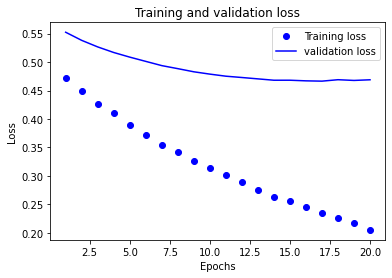

In [53]:
plt.plot(epochs, loss, 'bo', label='Training loss') # bo stands for "blue dot"
plt.plot(epochs, val_loss, 'b', label='validation loss') # b stands for "blue"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

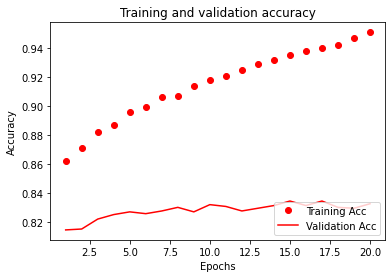

In [54]:
# Same plotting for the accuracy
plt.plot(epochs, acc, 'ro', label='Training Acc') # bo stands for "blue dot"
plt.plot(epochs, val_acc, 'r', label='Validation Acc') # b stands for "blue"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [57]:
# Export the model for the production use
Model_for_inference = tf.keras.Sequential([int_vectorize_layer, model, layers.Activation('sigmoid')])

In [58]:
Model_for_inference.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [59]:
loss_I, accuracy_I = Model_for_inference.evaluate(raw_test_ds)

500/500 [==============================] - 2s 3ms/step - loss: 0.5312 - accuracy: 0.8033


In [62]:
# inferencing on new data
def get_predicted_labels(predicted_scores_batch):
    predicted_int_labels = tf.argmax(predicted_scores_batch, axis=1)
    predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)
    
    return predicted_labels

In [63]:
examples = [
    
 "How do I extract keys from a dict into a list?", # PYTHON
 "debug public static void main(string[] args) { print('Hello world') }", # JAVA
 "console.log('Hello JS')",
    
]

In [64]:
predicted_scores = Model_for_inference.predict(examples)

In [65]:
predicted_labels = get_predicted_labels(predicted_scores)

In [66]:
predicted_scores

array([[0.43195593, 0.36770427, 0.47404352, 0.809546  ],
       [0.8068458 , 0.8922657 , 0.07144797, 0.05808821],
       [0.48185712, 0.37804326, 0.89270663, 0.26702103]], dtype=float32)

In [67]:
predicted_labels

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'python', b'java', b'javascript'], dtype=object)>

In [68]:
for example, label in zip(examples, predicted_labels):
    print("question: ", example)
    print("Predicted label;", label.numpy())

question:  How do I extract keys from a dict into a list?
Predicted label; b'python'
question:  debug public static void main(string[] args) { print('Hello world') }
Predicted label; b'java'
question:  console.log('Hello JS')
Predicted label; b'javascript'
